<a href="https://colab.research.google.com/github/JiweiHou/3DINV/blob/master/video2masks_predictor.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Copyright (c) Meta Platforms, Inc. and affiliates.

In [3]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Video segmentation with SAM 2

This notebook shows how to use SAM 2 for interactive segmentation in videos. It will cover the following:

- adding clicks (or box) on a frame to get and refine _masklets_ (spatio-temporal masks)
- propagating clicks (or box) to get _masklets_ throughout the video
- segmenting and tracking multiple objects at the same time

We use the terms _segment_ or _mask_ to refer to the model prediction for an object on a single frame, and _masklet_ to refer to the spatio-temporal masks across the entire video.

<a target="_blank" href="https://colab.research.google.com/github/facebookresearch/sam2/blob/main/notebooks/video_predictor_example.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

## Environment Set-up

If running locally using jupyter, first install `sam2` in your environment using the [installation instructions](https://github.com/facebookresearch/sam2#installation) in the repository.

If running from Google Colab, set `using_colab=True` below and run the cell. In Colab, be sure to select 'GPU' under 'Edit'->'Notebook Settings'->'Hardware accelerator'. Note that it's recommended to use **A100 or L4 GPUs when running in Colab** (T4 GPUs might also work, but could be slow and might run out of memory in some cases).

In [4]:
using_colab = True

In [5]:
if using_colab:
    import torch
    import torchvision
    print("PyTorch version:", torch.__version__)
    print("Torchvision version:", torchvision.__version__)
    print("CUDA is available:", torch.cuda.is_available())
    import sys
    !{sys.executable} -m pip install opencv-python matplotlib
    !{sys.executable} -m pip install 'git+https://github.com/facebookresearch/sam2.git'

PyTorch version: 2.5.1+cu121
Torchvision version: 0.20.1+cu121
CUDA is available: True
  Cloning https://github.com/facebookresearch/sam2.git to /tmp/pip-req-build-7d7z62ix
  Running command git clone --filter=blob:none --quiet https://github.com/facebookresearch/sam2.git /tmp/pip-req-build-7d7z62ix
  Resolved https://github.com/facebookresearch/sam2.git to commit c2ec8e14a185632b0a5d8b161928ceb50197eddc
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.2/42.2 kB 2.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 117.0/117.0 kB 6.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.5/154.5 kB 12.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.5/79.5 kB 6.6 MB/s eta 0:00:00
  Created wheel for SAM-2: filename=SAM_2-1.0-cp310-cp

In [6]:
!pip install opencv-python opencv-python-headless

In [ ]:
import cv2
import os

# 定义帧所在的目录和输出视频路径
frame_dir = "/content/drive/MyDrive/video2masks/masked_frames2"  # 替换为帧文件夹路径
output_video_path = "/content/drive/MyDrive/video2masks/mask_hallway_video.mp4"  # 替换为输出视频路径
frame_rate = 30  # 视频帧率

# 获取帧的文件列表并排序
frame_files = sorted(
    [os.path.join(frame_dir, f) for f in os.listdir(frame_dir) if f.endswith(".jpg")]
)

# 检查是否有帧文件
if not frame_files:
    raise ValueError("没有找到任何帧文件，请检查路径或文件格式！")

# 读取第一帧以获取帧尺寸
first_frame = cv2.imread(frame_files[0])
if first_frame is None:
    raise ValueError("无法读取第一帧，请检查帧文件是否损坏！")
height, width, _ = first_frame.shape

# 初始化视频写入对象
video_writer = cv2.VideoWriter(
    output_video_path, cv2.VideoWriter_fourcc(*"mp4v"), frame_rate, (width, height)
)

# 将每一帧写入视频
for frame_file in frame_files:
    frame = cv2.imread(frame_file)
    if frame is None:
        print(f"警告：无法读取帧文件 {frame_file}，已跳过。")
        continue
    video_writer.write(frame)

# 释放视频写入对象
video_writer.release()
print(f"视频已保存到: {output_video_path}")


视频已保存到: /content/drive/MyDrive/video2masks/mask_hallway_video.mp4


## Set-up

In [38]:
import cv2
import os

def video_to_frames(video_path, output_folder, max_frames=100):
    # 创建保存帧的文件夹
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)

    # 打开视频文件
    video_capture = cv2.VideoCapture(video_path)
    if not video_capture.isOpened():
        print("无法打开视频文件:", video_path)
        return

    frame_count = 0
    total_frames = int(video_capture.get(cv2.CAP_PROP_FRAME_COUNT))  # 获取视频总帧数
    print(f"视频总帧数: {total_frames}")

    # 如果视频帧数超过 max_frames，计算提取帧的间隔
    interval = total_frames // max_frames if total_frames > max_frames else 1

    extracted_frames = 0  # 用来记录已提取的帧数
    while True:
        success, frame = video_capture.read()
        if not success:
            break

        # 如果当前帧符合提取间隔条件，保存该帧
        if extracted_frames < max_frames and frame_count % (interval) == 0:
            frame_filename = os.path.join(output_folder, f"{extracted_frames:05d}.jpg")
            cv2.imwrite(frame_filename, frame)
            print(f"已保存: {frame_filename}")
            extracted_frames += 1  # 更新提取帧数

        frame_count += 1

        # 如果已经提取了 max_frames 帧，停止
        if extracted_frames >= max_frames:
            break

    video_capture.release()
    print(f"完成！总共提取了 {extracted_frames} 帧。")

# 上传视频
video_path = "/content/drive/MyDrive/video2masks/scene3.MOV"  # 替换为实际文件名
output_folder = "/content/drive/MyDrive/video2masks/scene3_frames"  # 帧保存路径
video_to_frames(video_path, output_folder, max_frames=100)


视频总帧数: 884
已保存: /content/drive/MyDrive/video2masks/scene3_frames/00000.jpg
已保存: /content/drive/MyDrive/video2masks/scene3_frames/00001.jpg
已保存: /content/drive/MyDrive/video2masks/scene3_frames/00002.jpg
已保存: /content/drive/MyDrive/video2masks/scene3_frames/00003.jpg
已保存: /content/drive/MyDrive/video2masks/scene3_frames/00004.jpg
已保存: /content/drive/MyDrive/video2masks/scene3_frames/00005.jpg
已保存: /content/drive/MyDrive/video2masks/scene3_frames/00006.jpg
已保存: /content/drive/MyDrive/video2masks/scene3_frames/00007.jpg
已保存: /content/drive/MyDrive/video2masks/scene3_frames/00008.jpg
已保存: /content/drive/MyDrive/video2masks/scene3_frames/00009.jpg
已保存: /content/drive/MyDrive/video2masks/scene3_frames/00010.jpg
已保存: /content/drive/MyDrive/video2masks/scene3_frames/00011.jpg
已保存: /content/drive/MyDrive/video2masks/scene3_frames/00012.jpg
已保存: /content/drive/MyDrive/video2masks/scene3_frames/00013.jpg
已保存: /content/drive/MyDrive/video2masks/scene3_frames/00014.jpg
已保存: /content/drive/MyDrive/v

In [39]:
import os
# if using Apple MPS, fall back to CPU for unsupported ops
os.environ["PYTORCH_ENABLE_MPS_FALLBACK"] = "1"
import numpy as np
import torch
import matplotlib.pyplot as plt
from PIL import Image

In [40]:
# select the device for computation
if torch.cuda.is_available():
    device = torch.device("cuda")
elif torch.backends.mps.is_available():
    device = torch.device("mps")
else:
    device = torch.device("cpu")
print(f"using device: {device}")

if device.type == "cuda":
    # use bfloat16 for the entire notebook
    torch.autocast("cuda", dtype=torch.bfloat16).__enter__()
    # turn on tfloat32 for Ampere GPUs (https://pytorch.org/docs/stable/notes/cuda.html#tensorfloat-32-tf32-on-ampere-devices)
    if torch.cuda.get_device_properties(0).major >= 8:
        torch.backends.cuda.matmul.allow_tf32 = True
        torch.backends.cudnn.allow_tf32 = True
elif device.type == "mps":
    print(
        "\nSupport for MPS devices is preliminary. SAM 2 is trained with CUDA and might "
        "give numerically different outputs and sometimes degraded performance on MPS. "
        "See e.g. https://github.com/pytorch/pytorch/issues/84936 for a discussion."
    )

using device: cuda


### Loading the SAM 2 video predictor

In [41]:
from sam2.build_sam import build_sam2_video_predictor

sam2_checkpoint = "/content/drive/MyDrive/checkpoints/sam2.1_hiera_large.pt"
model_cfg = "configs/sam2.1/sam2.1_hiera_l.yaml"

predictor = build_sam2_video_predictor(model_cfg, sam2_checkpoint, device=device)

In [42]:
def show_mask(mask, ax, obj_id=None, random_color=False):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        cmap = plt.get_cmap("tab10")
        cmap_idx = 0 if obj_id is None else obj_id
        color = np.array([*cmap(cmap_idx)[:3], 0.6])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)


def show_points(coords, labels, ax, marker_size=200):
    pos_points = coords[labels==1]
    neg_points = coords[labels==0]
    ax.scatter(pos_points[:, 0], pos_points[:, 1], color='green', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)
    ax.scatter(neg_points[:, 0], neg_points[:, 1], color='red', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)


def show_box(box, ax):
    x0, y0 = box[0], box[1]
    w, h = box[2] - box[0], box[3] - box[1]
    ax.add_patch(plt.Rectangle((x0, y0), w, h, edgecolor='green', facecolor=(0, 0, 0, 0), lw=2))

#### Select an example video

We assume that the video is stored as a list of JPEG frames with filenames like `<frame_index>.jpg`.

For your custom videos, you can extract their JPEG frames using ffmpeg (https://ffmpeg.org/) as follows:
```
ffmpeg -i <your_video>.mp4 -q:v 2 -start_number 0 <output_dir>/'%05d.jpg'
```
where `-q:v` generates high-quality JPEG frames and `-start_number 0` asks ffmpeg to start the JPEG file from `00000.jpg`.

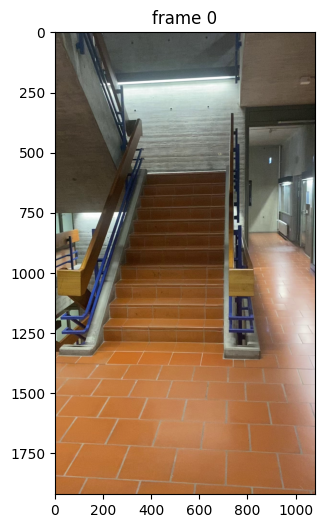

In [43]:
# `video_dir` a directory of JPEG frames with filenames like `<frame_index>.jpg`
video_dir = "/content/drive/MyDrive/video2masks/scene3_frames"

# scan all the JPEG frame names in this directory
frame_names = [
    p for p in os.listdir(video_dir)
    if os.path.splitext(p)[-1] in [".jpg", ".jpeg", ".JPG", ".JPEG"]
]
frame_names.sort(key=lambda p: int(os.path.splitext(p)[0]))

# take a look the first video frame
frame_idx = 0
plt.figure(figsize=(9, 6))
plt.title(f"frame {frame_idx}")
plt.imshow(Image.open(os.path.join(video_dir, frame_names[frame_idx])))

#### Initialize the inference state

SAM 2 requires stateful inference for interactive video segmentation, so we need to initialize an **inference state** on this video.

During initialization, it loads all the JPEG frames in `video_path` and stores their pixels in `inference_state` (as shown in the progress bar below).

In [44]:
inference_state = predictor.init_state(video_path=video_dir)

frame loading (JPEG): 100%|██████████| 100/100 [00:10<00:00,  9.42it/s]


### Example 1: Segment & track one object

Note: if you have run any previous tracking using this `inference_state`, please reset it first via `reset_state`.

(The cell below is just for illustration; it's not needed to call `reset_state` here as this `inference_state` is just freshly initialized above.)

In [45]:
predictor.reset_state(inference_state)

#### Step 1: Add a first click on a frame

To get started, let's try to segment the child on the left.

Here we make a **positive click** at (x, y) = (210, 350) with label `1`, by sending their coordinates and labels into the `add_new_points_or_box` API.

Note: label `1` indicates a *positive click (to add a region)* while label `0` indicates a *negative click (to remove a region)*.

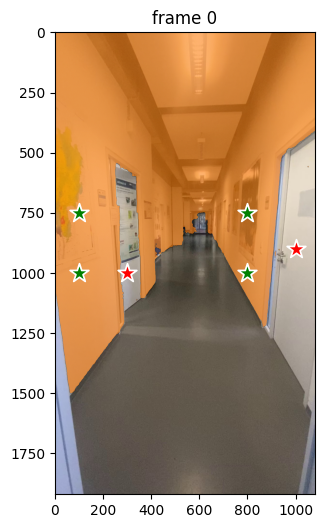

In [35]:
ann_frame_idx = 0  # the frame index we interact with
ann_obj_id = 1  # give a unique id to each object we interact with (it can be any integers)

# Let's add a positive click at (x, y) = (210, 350) to get started
points = np.array([[800, 1000],[100, 1000],[100, 750],[800, 750],[300, 1000],[1000, 900]], dtype=np.float32)
# for labels, `1` means positive click and `0` means negative click
labels = np.array([1,1,1,1,0,0], np.int32)
_, out_obj_ids, out_mask_logits = predictor.add_new_points_or_box(
    inference_state=inference_state,
    frame_idx=ann_frame_idx,
    obj_id=ann_obj_id,
    points=points,
    labels=labels,
)

# show the results on the current (interacted) frame
plt.figure(figsize=(9, 6))
plt.title(f"frame {ann_frame_idx}")
plt.imshow(Image.open(os.path.join(video_dir, frame_names[ann_frame_idx])))
show_points(points, labels, plt.gca())
show_mask((out_mask_logits[0] > 0.0).cpu().numpy(), plt.gca(), obj_id=out_obj_ids[0])

#### Step 2: Add a second click to refine the prediction

Hmm, it seems that although we wanted to segment the child on the left, the model predicts the mask for only the shorts -- this can happen since there is ambiguity from a single click about what the target object should be. We can refine the mask on this frame via another positive click on the child's shirt.

Here we make a **second positive click** at (x, y) = (250, 220) with label `1` to expand the mask.

Note: we need to send **all the clicks and their labels** (i.e. not just the last click) when calling `add_new_points_or_box`.

propagate in video: 100%|██████████| 359/359 [07:00<00:00,  1.17s/it]


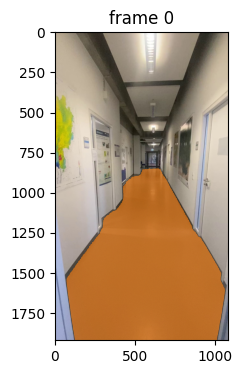

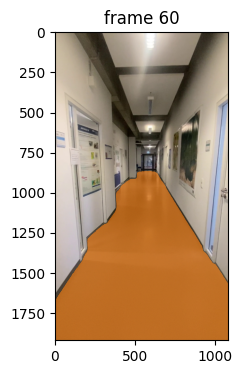

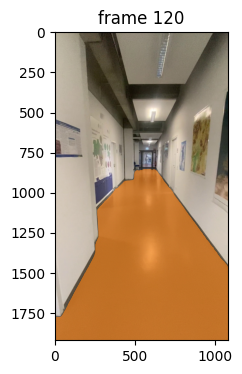

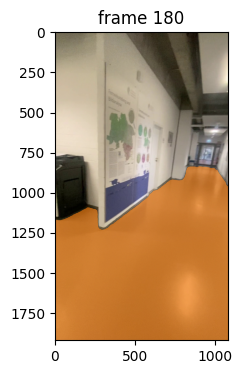

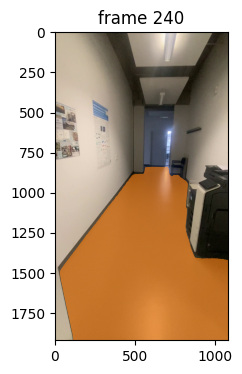

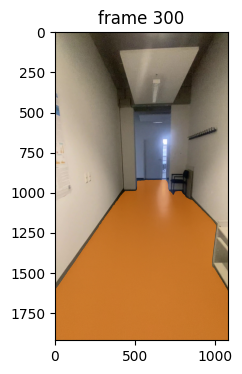

In [ ]:
# run propagation throughout the video and collect the results in a dict
video_segments = {}  # video_segments contains the per-frame segmentation results
for out_frame_idx, out_obj_ids, out_mask_logits in predictor.propagate_in_video(inference_state):
    video_segments[out_frame_idx] = {
        out_obj_id: (out_mask_logits[i] > 0.0).cpu().numpy()
        for i, out_obj_id in enumerate(out_obj_ids)
    }

# render the segmentation results every few frames
vis_frame_stride = 60
plt.close("all")
for out_frame_idx in range(0, len(frame_names), vis_frame_stride):
    plt.figure(figsize=(6, 4))
    plt.title(f"frame {out_frame_idx}")
    plt.imshow(Image.open(os.path.join(video_dir, frame_names[out_frame_idx])))
    for out_obj_id, out_mask in video_segments[out_frame_idx].items():
        show_mask(out_mask, plt.gca(), obj_id=out_obj_id)

In [ ]:
import cv2
import os
from PIL import Image
import matplotlib.pyplot as plt

# 创建输出目录
output_masked_frames_dir = "/content/drive/MyDrive/video2masks/masked_frames2"
os.makedirs(output_masked_frames_dir, exist_ok=True)

# 定义帧保存路径
output_video_path = "/content/drive/MyDrive/video2masks/output_hallway_with_masks.mp4"
frame_rate = 30  # 设置帧率

# 初始化字典，保存分割结果
video_segments = {}  # video_segments contains the per-frame segmentation results

# 运行分割传播并存储每帧结果
for out_frame_idx, out_obj_ids, out_mask_logits in predictor.propagate_in_video(inference_state):
    if out_frame_idx % 2 == 0:  # 每隔2帧处理一次
        video_segments[out_frame_idx] = {
            out_obj_id: (out_mask_logits[i] > 0.0).cpu().numpy()
            for i, out_obj_id in enumerate(out_obj_ids)
        }

# 遍历所有帧并保存带 mask 的帧
for out_frame_idx in range(0, len(frame_names), 2):  # 每隔2帧渲染
    # 打开原始帧
    original_frame = Image.open(os.path.join(video_dir, frame_names[out_frame_idx]))
    plt.figure(figsize=(6, 4))
    plt.imshow(original_frame)

    # 在帧上绘制 masks
    for out_obj_id, out_mask in video_segments.get(out_frame_idx, {}).items():
        show_mask(out_mask, plt.gca(), obj_id=out_obj_id)

    # 保存当前帧
    plt.axis("off")
    output_path = os.path.join(output_masked_frames_dir, f"masked_frame_{out_frame_idx:05d}.jpg")
    plt.savefig(output_path, bbox_inches='tight', pad_inches=0)
    plt.close()
    print(f"已保存: {output_path}")

# 获取所有保存的帧，并排序
masked_frame_paths = sorted(
    [os.path.join(output_masked_frames_dir, f) for f in os.listdir(output_masked_frames_dir) if f.endswith(".jpg")]
)

# 获取第一帧以获取视频的宽和高
first_frame = cv2.imread(masked_frame_paths[0])
height, width, _ = first_frame.shape

# 初始化视频写入对象
video_writer = cv2.VideoWriter(
    output_video_path, cv2.VideoWriter_fourcc(*"mp4v"), frame_rate, (width, height)
)

# 将每一帧写入视频
for frame_path in masked_frame_paths:
    frame = cv2.imread(frame_path)
    video_writer.write(frame)

# 释放视频写入对象
video_writer.release()
print(f"视频已保存到: {output_video_path}")


propagate in video: 100%|██████████| 359/359 [07:00<00:00,  1.17s/it]


已保存: /content/drive/MyDrive/video2masks/masked_frames2/masked_frame_00000.jpg
已保存: /content/drive/MyDrive/video2masks/masked_frames2/masked_frame_00002.jpg
已保存: /content/drive/MyDrive/video2masks/masked_frames2/masked_frame_00004.jpg
已保存: /content/drive/MyDrive/video2masks/masked_frames2/masked_frame_00006.jpg
已保存: /content/drive/MyDrive/video2masks/masked_frames2/masked_frame_00008.jpg
已保存: /content/drive/MyDrive/video2masks/masked_frames2/masked_frame_00010.jpg
已保存: /content/drive/MyDrive/video2masks/masked_frames2/masked_frame_00012.jpg
已保存: /content/drive/MyDrive/video2masks/masked_frames2/masked_frame_00014.jpg
已保存: /content/drive/MyDrive/video2masks/masked_frames2/masked_frame_00016.jpg
已保存: /content/drive/MyDrive/video2masks/masked_frames2/masked_frame_00018.jpg
已保存: /content/drive/MyDrive/video2masks/masked_frames2/masked_frame_00020.jpg
已保存: /content/drive/MyDrive/video2masks/masked_frames2/masked_frame_00022.jpg
已保存: /content/drive/MyDrive/video2masks/masked_frames2/masked_fr

In [ ]:
import cv2
import os
from PIL import Image

# 创建输出目录
output_masked_frames_dir = "/content/drive/MyDrive/video2masks/masked_frames"
os.makedirs(output_masked_frames_dir, exist_ok=True)

# 保存带 mask 的每一帧
for out_frame_idx in range(len(frame_names)):
    # 打开原始帧
    original_frame = Image.open(os.path.join(video_dir, frame_names[out_frame_idx]))
    plt.figure(figsize=(6, 4))
    plt.imshow(original_frame)

    # 在帧上绘制 masks
    for out_obj_id, out_mask in video_segments.get(out_frame_idx, {}).items():
        show_mask(out_mask, plt.gca(), obj_id=out_obj_id)

    # 保存当前帧
    plt.axis("off")
    output_path = os.path.join(output_masked_frames_dir, f"masked_frame_{out_frame_idx:05d}.jpg")
    plt.savefig(output_path, bbox_inches='tight', pad_inches=0)
    plt.close()
    print(f"已保存: {output_path}")

# 将帧合成为 MP4
output_video_path = "/content/drive/MyDrive/video2masks/output_hallway_with_masks.mp4"
frame_rate = 30  # 设置帧率

# 获取所有保存的帧，并排序
masked_frame_paths = sorted(
    [os.path.join(output_masked_frames_dir, f) for f in os.listdir(output_masked_frames_dir) if f.endswith(".jpg")]
)

# 获取第一帧以获取视频的宽和高
first_frame = cv2.imread(masked_frame_paths[0])
height, width, _ = first_frame.shape

# 初始化视频写入对象
video_writer = cv2.VideoWriter(
    output_video_path, cv2.VideoWriter_fourcc(*"mp4v"), frame_rate, (width, height)
)

# 将每一帧写入视频
for frame_path in masked_frame_paths:
    frame = cv2.imread(frame_path)
    video_writer.write(frame)

# 释放视频写入对象
video_writer.release()
print(f"视频已保存到: {output_video_path}")


NameError: name 'frame_names' is not defined